# Applied Machine Learning - Project (Python)

## Belma Muftic
## D17127216

### 20.05.2018

In [154]:
import csv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn import neighbors, metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score,LeaveOneOut, StratifiedKFold
from sklearn.metrics import confusion_matrix

In [155]:
train = pd.read_csv('train.csv').as_matrix()
copyT = train
outcome = train[:, 1:2]

train = train[:, 2:12]

In [156]:
#Sex
#convert it into two classes according to gender
train[train=='male']=1
train[train=='female']=2


#Embarked
#convert into three classes, since there are three possible values
#missing data: count for each ticket class how many passengers embarked from that port, seperately for men and women
#the missing value will be the embarked value with the maximum count for the class and gender of the person's missing info

train[train=='S']=1
train[train=='C']=2
train[train=='Q']=3
counterM=[[0,0,0],[0,0,0],[0,0,0]]
counterF=[[0,0,0],[0,0,0],[0,0,0]]
extract = train[:,9:10]

for i in range(0,len(train)):
    if((math.isnan(extract[i])==False) & (train[i][2]==1)): #male
        embarked = train[i][9]-1
        Pclass=copyT[i][2]-1
        counterM[Pclass][embarked]=counterM[Pclass][embarked]+1
    elif((math.isnan(extract[i])==False) & (train[i][2]==2)):
        embarked = train[i][9]-1
        Pclass=copyT[i][2]-1
        counterF[Pclass][embarked]=counterF[Pclass][embarked]+1

for i in range(0,len(train)):
    if((math.isnan(extract[i])==True) & (train[i][2]==1)):
        Pclass=copyT[i][2]-1
        train[i,9]=np.argmax(counterM[Pclass])+1
    elif((math.isnan(extract[i])==True) & (train[i][2]==2)):
        Pclass=copyT[i][2]-1
        train[i,9]=np.argmax(counterF[Pclass])+1
        
#Fare
#the transformation is based on roughly established data
#it classifies the passengers into 6 categories
extract = train[:,7:8]
extract[extract<1]=1
extract[(extract<=25) & (extract>=1)]=2
extract[(extract<=55) & (extract>25)]=3
extract[(extract<=85) & (extract>55)]=4
extract[(extract<=120) & (extract>85)]=5
extract[extract>120]=6
train[:,7:8]=extract

#Cabin
#the transofrmation is merely based on whether the person had a cabin or not
extract = train[:,8:9]
extract[extract=='']=0
extract[extract!='']=1
train[:,8:9]=extract

#Age
#in order to deal with missing values for the age of the passengers, the following parameters were included for forming groups:
#1. Sex
#2. Title for the women (if it is 'Miss' or 'Mrs/Ms')
#3. Class
#the missing value is the appropriate average value for that person's sex, title and class
#the age classiffication is based on 8 categories:
#1. toddlers
#2. children
#3. teens
#4. young adults (not married, or married without children)
#5. aged between 25 and 35, likely to have small children with them
#6. aged between 35 and 50, likely to be travelling by business
#7. aged between 50 and 65, likely to be travelling with their spouse
#8. old people who might be incapable of rescuing themselves

sumMiss = [0,0,0]
sumMrs = [0,0,0]
counterMiss=[0,0,0]
counterMrs=[0,0,0]

for i in range(0, len(copyT)):
    
    if((copyT[i][4]==2) & ('Miss' in copyT[i][3]) & (math.isnan(copyT[i][5])==False)):
        Pclass=copyT[i][2]-1
        age = copyT[i][5]
        sumMiss[Pclass]=sumMiss[Pclass]+age
        counterMiss[Pclass]=counterMiss[Pclass]+1
    elif((copyT[i][4]==2) & (('Mrs' in copyT[i][3]) | ('Ms' in copyT[i][3])) & (math.isnan(copyT[i][5])==False)):
        Pclass=copyT[i][2]-1
        age = copyT[i][5]
        sumMrs[Pclass]=sumMrs[Pclass]+age
        counterMrs[Pclass]=counterMrs[Pclass]+1

resultMiss = [a/b for a,b in zip(sumMiss, counterMiss)]
resultMrs = [a/b for a,b in zip(sumMrs, counterMrs)]

for i in range(0, len(train)):
    if((copyT[i][4]==2) & ('Miss' in copyT[i][3]) & (math.isnan(copyT[i][5])==True)):
        Pclass=copyT[i][2]-1
        train[i][3]=round(resultMiss[Pclass])
    elif((copyT[i][4]==2) & (('Mrs' in copyT[i][3]) | ('Ms' in copyT[i][3])) & (math.isnan(copyT[i][5])==True)):
        Pclass=copyT[i][2]-1
        train[i][3]=round(resultMrs[Pclass])

sumMr=[0,0,0]
counterMr=[0,0,0]
for i in range(0, len(copyT)):
    
    if((copyT[i][4]==1) & (math.isnan(copyT[i][5])==False)):
        Pclass=copyT[i][2]-1
        age = copyT[i][5]
        sumMr[Pclass]=sumMr[Pclass]+age
        counterMr[Pclass]=counterMr[Pclass]+1

resultMr = [a/b for a,b in zip(sumMr, counterMr)]

for i in range(0, len(train)):
    if((copyT[i][4]==1) & (math.isnan(copyT[i][5])==True)):
        Pclass=copyT[i][2]-1
        train[i][3]=round(resultMr[Pclass])

        
#classify age
extract=train[:,3:4]
extract[extract<=5]=1
extract[(extract<=13) & (extract>5)]=2
extract[(extract<=18) & (extract>13)]=3
extract[(extract<=25) & (extract>18)]=4
extract[(extract<=35) & (extract>25)]=5
extract[(extract<=50) & (extract>35)]=6
extract[(extract<=65) & (extract>50)]=7
extract[extract>65]=8
train[:,3:4]=extract

        
#Sibling/Spouse
#this transformation lets us roughly differentiate between:
#1. persons travelling alone
#2. persons with a spouse
#3. children
#NOTE: of course, not all children have more than 1 sibling, but for simplicity, that was the assumption I made
extract = train[:,4:5]
extract[extract>1]=3
extract[extract==1]=2
extract[extract==0]=1
train[:,4:5]=extract

#Parent/Children
#this transformation lets us roughly differentiate between:
#1. persons travelling alone
#2. parents and children
extract = train[:,5:6]
extract[extract>0]=2
extract[extract==0]=1
train[:,5:6]=extract

#Ticket
#if the ticket has PC in its value, that indicates a person from the first class
for i in range(0,len(train)):
    if ('PC' in train[i][6]):
        train[i][6]=1
    elif('PC' not in train[i][6]):
        train[i][6]=0


#delete name column since it cannot be used, unless it is compared to names which were an indication of wealth then
train=np.delete(train, 1, 1)

In [157]:
test = pd.read_csv('test.csv').as_matrix()
truth = np.genfromtxt('truth.csv', dtype='unicode', delimiter=',')
test=test[:,1:]

#the transformation is same as with the train data

#Sex
test[test=='male']=1
test[test=='female']=2

#Embarked
test[test=='S']=1
test[test=='C']=2
test[test=='Q']=3
counterM=[[0,0,0],[0,0,0],[0,0,0]]
counterF=[[0,0,0],[0,0,0],[0,0,0]]
extract = test[:,9:10]

for i in range(0,len(test)):
    if((math.isnan(extract[i])==False) & (test[i][2]==1)): #male
        embarked = test[i][9]-1
        Pclass=test[i][0]-1
        counterM[Pclass][embarked]=counterM[Pclass][embarked]+1
    elif((math.isnan(extract[i])==False) & (test[i][2]==2)):
        embarked = test[i][9]-1
        Pclass=test[i][0]-1
        counterF[Pclass][embarked]=counterF[Pclass][embarked]+1      
        
for i in range(0,len(test)):
    if((math.isnan(test[i,9])==True) & (test[i][2]==1)):
        Pclass=test[i][0]-1
        test[i,9]=np.argmax(counterM[Pclass])+1
    elif((math.isnan(test[i,9])==True) & (test[i][2]==2)):
        Pclass=test[i][0]-1
        test[i,9]=np.argmax(counterF[Pclass])+1

        
#Fare
#missing values: find the average fare for the ticket a man/woman paid
fareM = list()
fareF = list()
for i in range(0,len(test)):
    if ((test[i,2]==1) & (math.isnan(test[i,7])==False)):
        fareM.append(test[i,7])
    elif ((test[i,2]==2) & (math.isnan(test[i,7])==False)):
        fareF.append(test[i,7])
        
for i in range(0,len(test)):
    if ((test[i,2]==1) & (math.isnan(test[i,7]))):
        test[i,7]=np.average(fareM)
    elif ((test[i,2]==2) & (math.isnan(test[i,7]))):
        test[i,7]=np.average(fareF)

extract = test[:,7:8]
extract[extract<1]=1
extract[(extract<=25) & (extract>=1)]=2
extract[(extract<=55) & (extract>25)]=3
extract[(extract<=85) & (extract>55)]=4
extract[(extract<=120) & (extract>85)]=5
extract[extract>120]=6
test[:,7:8]=extract

#Cabin
extract = test[:,8:9]
extract[extract=='']=0
extract[extract!='']=1
test[:,8:9]=extract

#Age
sumMiss = [0,0,0]
sumMrs = [0,0,0]
counterMiss=[0,0,0]
counterMrs=[0,0,0]

for i in range(0, len(test)):
    
    if((test[i][2]==2) & ('Miss' in test[i][1]) & (math.isnan(test[i][3])==False)):
        Pclass=test[i][0]-1
        age = test[i][3]
        sumMiss[Pclass]=sumMiss[Pclass]+age
        counterMiss[Pclass]=counterMiss[Pclass]+1
    elif((test[i][2]==2) & (('Mrs' in test[i][1]) | ('Ms' in test[i][1])) & (math.isnan(test[i][3])==False)):
        Pclass=test[i][0]-1
        age = test[i][3]
        sumMrs[Pclass]=sumMrs[Pclass]+age
        counterMrs[Pclass]=counterMrs[Pclass]+1

resultMiss = [a/b for a,b in zip(sumMiss, counterMiss)]
resultMrs = [a/b for a,b in zip(sumMrs, counterMrs)]

for i in range(0, len(test)):
    if((test[i][2]==2) & ('Miss' in test[i][1]) & (math.isnan(test[i][3])==True)):
        Pclass=test[i][0]-1
        test[i][3]=round(resultMiss[Pclass])
    elif((test[i][2]==2) & (('Mrs' in test[i][1]) | ('Ms' in test[i][1])) & (math.isnan(test[i][3])==True)):
        Pclass=test[i][0]-1
        test[i][3]=round(resultMrs[Pclass])

sumMr=[0,0,0]
counterMr=[0,0,0]
for i in range(0, len(test)):
    
    if((test[i][2]==1) & (math.isnan(test[i][3])==False)):
        Pclass=test[i][0]-1
        age = test[i][3]
        sumMr[Pclass]=sumMr[Pclass]+age
        counterMr[Pclass]=counterMr[Pclass]+1

resultMr = [a/b for a,b in zip(sumMr, counterMr)]

for i in range(0, len(test)):
    if((test[i][2]==1) & (math.isnan(test[i][3])==True)):
        Pclass=test[i][0]-1
        test[i][3]=round(resultMr[Pclass])
        
#classify age
extract=test[:,3:4]

extract[extract<=5]=1
extract[(extract<=13) & (extract>5)]=2
extract[(extract<=18) & (extract>13)]=3
extract[(extract<=25) & (extract>18)]=4
extract[(extract<=35) & (extract>25)]=5
extract[(extract<=50) & (extract>35)]=6
extract[(extract<=65) & (extract>50)]=7
extract[extract>65]=8
test[:,3:4]=extract 
    
        
#Sibling/Spouse
extract = test[:,4:5]
extract[extract>1]=3
extract[extract==1]=2
extract[extract==0]=1
test[:,4:5]=extract

#Parent/Children
extract = test[:,5:6]
extract[extract>0]=2
extract[extract==0]=1
test[:,5:6]=extract

#Ticket
for i in range(0,len(test)):
    if ('PC' in test[i][6]):
        test[i][6]=1
    elif('PC' not in test[i][6]):
        test[i][6]=0

        
#delete name column
test=np.delete(test, 1, 1)


#the code below saves the transformed data so that it can be used by exercise 2 (clustering in R)
#NOTE: after it is modified, the first row of the file is changed to indicate the header
#the row is: PassengerId,Pclass,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked

# df = pd.DataFrame(train)
# df.to_csv("trainModified.csv") 

In [158]:
#KNN
tempOutcome = outcome
tempTrain = train
tempTest = test
tempTruth = truth
outcome = outcome.ravel()
outcome=outcome.astype('int')
train = train.tolist()
truth = truth.astype('int')
test= test.tolist()
bestScore = 0
bestK = 1
for k in range (1,36):
    temp = neighbors.KNeighborsClassifier(k)
    temp.fit(train, outcome)
    
    results = temp.predict(test)
    score = metrics.accuracy_score(truth, results)
    if (score>bestScore):
        bestK=k
        bestScore=score
        
temp = neighbors.KNeighborsClassifier(bestK)
temp.fit(train, outcome)    
results = temp.predict(test)
print('Optimum value for k: '+str(bestK))

Optimum value for k: 2


[[ 0.63404255  0.46994536]
 [ 0.47234043  0.39344262]]


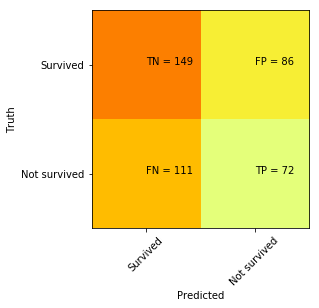

In [159]:
#Naive Bayes NB
model = GaussianNB()
model.fit(train, outcome)
predicted = model.predict(test)

#classification accuracy
acc = accuracy_score(predicted, truth)
#this array will contain accuracies for the classifiers from question 4
accuracyResults = np.array([])
accuracyResults = np.append(accuracyResults, ['Naive Bayes', acc], axis=0)

#classification performance
M = confusion_matrix(truth, predicted)
avr = M.astype(float) / M.sum(axis=1)
print avr

#visual representation of classification performance
plt.clf()
plt.imshow(M, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Survived','Not survived']
plt.ylabel('Truth')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(M[i][j]))
plt.show()

[[ 0.65957447  0.43715847]
 [ 0.47234043  0.39344262]]


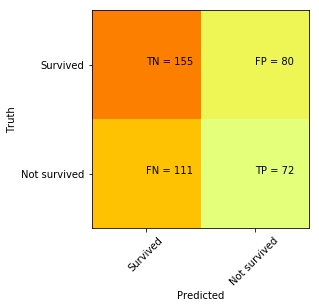

In [160]:
#SVM

#this array will contain classification accuracies for all SVM methods
accuracySVM = np.array([])

clf=svm.SVC(kernel='linear')
clf.fit(train,outcome) 
predL = clf.predict(test)
acc = accuracy_score(predL, truth)

accuracySVM = np.append(accuracySVM, ["linear", acc], axis=0)

clf=svm.SVC(kernel='rbf')
clf.fit(train,outcome) 
predRBF = clf.predict(test)
acc = accuracy_score(predRBF, truth)

accuracySVM = np.append(accuracySVM, ["RBF", acc], axis=0)

for i in range (2,11):
    clf = svm.SVC(degree=i)
    clf.fit(train,outcome) 
    pred = clf.predict(test)
    acc = accuracy_score(pred, truth)

    accuracySVM = np.append(accuracySVM, ["polynomial with degree "+str(i), acc], axis=0)

accuracySVM.resize(11,2)
temp = accuracySVM[:,1]
temp = np.array(temp).astype(np.float)
accuracyResults = np.append(accuracyResults, [accuracySVM[np.argmax(temp),0], accuracySVM[np.argmax(temp),1]], axis=0)

#classification performance
M = confusion_matrix(truth, predL)
avr = M.astype(float) / M.sum(axis=1)
print avr

#visual representation of classification performance for linear SVM
plt.clf()
plt.imshow(M, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Survived','Not survived']
plt.ylabel('Truth')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(M[i][j]))
plt.show()

[[ 0.67234043  0.42076503]
 [ 0.50638298  0.34972678]]


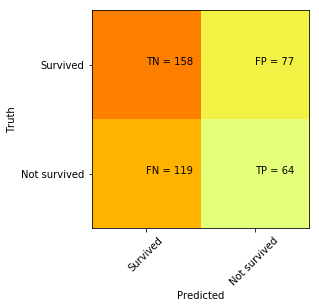

In [161]:
#Random Forest
clf = RandomForestClassifier(n_estimators = 2, random_state=3)
clf.fit(train,outcome)
result = clf.predict(test)

#classification accuracy
acc = accuracy_score(result, truth)

accuracyResults = np.append(accuracyResults, ['Random Forest', acc], axis=0)

#classification performance
M = confusion_matrix(truth, result)
avr = M.astype(float) / M.sum(axis=1)
print avr

#visual representation of classification performance for linear SVM
plt.clf()
plt.imshow(M, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Survived','Not survived']
plt.ylabel('Truth')
plt.xlabel('Predicted')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(M[i][j]))
plt.show()

In [162]:
#which classifier gives best results from question 4
accuracyResults.resize(3,2)
temp = accuracyResults[:,1]
temp = np.array(temp).astype(np.float)
print(accuracyResults[np.argmax(temp),0] + " achieves best performances " + accuracyResults[np.argmax(temp),1])

linear achieves best performances 0.543062200957


In [163]:
allData = np.concatenate((train, test), axis=0)
allOutcome = np.concatenate((outcome, truth), axis=0)

In [164]:
#Cross validation(s)

In [165]:
k_fold = KFold(n_splits=10,random_state=1234567890,shuffle=True)
svc = svm.SVC()
g=cross_val_score(svc, allData, allOutcome, cv=k_fold)
accuracyKfold=np.average(g)
print(accuracyKfold)

0.726482677628


In [166]:
k_fold = LeaveOneOut()
svc = svm.SVC()
resLOO=cross_val_score(svc, allData, allOutcome, cv=k_fold)
accuracyLOO=resLOO.mean()
print(accuracyLOO)

0.72192513369


In [167]:
k_fold = StratifiedKFold(n_splits=10)
svc = svm.SVC()
resStrat=cross_val_score(svc, allData, allOutcome, cv=k_fold, n_jobs=-1)
accuracyStratKfold=np.average(resStrat)
print(accuracyStratKfold)

0.724360308902
